In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Podesavanje uredjaja (GPU ako je dostupan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristi se uredjaj: {device}")

Koristi se uredjaj: cpu


In [2]:
#================================================================
# 1. DEFINISANJE "PRAVOG" FIZICKOG SISTEMA I GENERISANJE PODATAKA
#================================================================

# Parametri potencijala sa dva bunara i "temperatura" (kT=1)
A = 0.2
B = 2.0
KT = 1.0

def energy_potential(x):
    """Energija potencijala E(x) = a*x^4 - b*x^2"""
    return A * x**4 - B * x**2

def true_score(x):
    """Prava funkcija skora = -Nabla(E(x))/kT"""
    # Nabla(E(x)) = 4*A*x^3 - 2*B*x
    # Sila F(x) = -Nabla(E(x))
    # Score = Sila / kT
    return -(4 * A * x**3 - 2 * B * x) / KT

def generate_data_mcmc(num_samples=20000, burn_in=5000):
    """Generise podatke iz Bolcmanove distribucije pomocu Metropolis-Hastings"""
    samples = []
    x_current = torch.tensor([0.0])

    # Unnormalized probability p(x) ~ exp(-E(x)/kT)
    unnormalized_prob = lambda x: torch.exp(-energy_potential(x) / KT)

    for _ in range(num_samples + burn_in):
        # Predlog novog stanja iz Gausove raspodele
        x_proposal = x_current + torch.randn(1) * 0.5

        # Odnos verovatnoca
        prob_ratio = unnormalized_prob(x_proposal) / unnormalized_prob(x_current)

        # Prihvatanje ili odbacivanje
        if torch.rand(1) < prob_ratio:
            x_current = x_proposal

        if _ >= burn_in:
            samples.append(x_current.clone())

    return torch.cat(samples).unsqueeze(1).to(device)

print("Generisanje podataka iz termodinamickog sistema...")
data = generate_data_mcmc()
print(f"Generisano {data.shape[0]} uzoraka.")

Generisanje podataka iz termodinamickog sistema...
Generisano 20000 uzoraka.


In [3]:
#================================================================
# 2. DEFINISANJE SCORE MODELA (NEURONSKE MREZE)
#================================================================
class ScoreNet(nn.Module):
    """Jednostavna neuronska mreza koja uci score funkciju s(x, sigma)"""
    def __init__(self):
        super().__init__()
        # Mreza koja prima x i sigma i vraca score
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x, sigma):
        # Spajamo x i sigma da bi bili ulaz u mrezu
        # Sigma treba da bude istog oblika kao x za konkatenaciju
        sigma_reshaped = sigma.view(-1, 1).expand_as(x)
        x_sigma = torch.cat([x, sigma_reshaped], dim=1)
        return self.net(x_sigma)

In [6]:
#================================================================
# 3. TRENIRANJE MODELA KORISTECI DENOISING SCORE MATCHING
#================================================================
def train_score_model(model, data, epochs=5000, lr=1e-5, batch_size=256):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Definisemo nivoe suma (annealing schedule)
    # Geometrijska progresija od veceg ka manjem sumu
    sigmas = torch.exp(torch.linspace(np.log(20.0), np.log(0.05), 20)).to(device)

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch_x in data_loader:
            # Nasumicno biramo nivo suma za ovaj batch
            sigma_idx = torch.randint(0, len(sigmas), (batch_x.shape[0],)).to(device)
            sigma = sigmas[sigma_idx].view(-1, 1)

            # Korak 1: Perturbacija podataka (dodavanje suma)
            noise = torch.randn_like(batch_x)
            perturbed_x = batch_x + noise * sigma

            # Korak 2: Predvidjanje skora od strane mreze
            predicted_score = model(perturbed_x, sigma)

            # Korak 3: Izracunavanje ciljnog skora (DSM insight)
            # Cilj je da se nauci -noise/sigma, sto je gradijent log p(perturbed_x|x)
            target_score = -noise / sigma

            # Korak 4: Racunanje gubitka (loss) i optimizacija
            loss = ((predicted_score - target_score)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoha [{epoch+1}/{epochs}], Gubitak: {total_loss/len(data_loader):.4f}")

    return model, sigmas


print("\nPocinje treniranje Score Modela...")
score_model = ScoreNet().to(device)
trained_model, sigmas = train_score_model(score_model, data)
print("Treniranje zavrseno.")

#================================================================
# 4. GENERISANJE UZORAKA KORISTECI ANNEALED LANGEVIN DYNAMICS
#================================================================
@torch.no_grad()
def annealed_langevin_sampling(model, sigmas, num_samples=5000, steps_per_sigma=100):
    """Generise nove uzorke prateci gradijent naucenog skora."""
    model.eval()

    # Inicijalizujemo uzorke iz Gausove raspodele sa najvecim sumom
    x_t = torch.randn(num_samples, 1).to(device) * sigmas[0]

    # Annealing petlja: od najveceg do najmanjeg suma
    for i in tqdm(range(len(sigmas)), desc="Annealed Langevin Sampling"):
        sigma = sigmas[i]

        # Podesavanje velicine koraka (step size)
        # Manji korak za manji sum
        alpha = 1e-5 * (sigma / sigmas[-1])**2

        # Langevin koraci za trenutni nivo suma
        for _ in range(steps_per_sigma):
            score = model(x_t, sigma)
            noise = torch.randn_like(x_t)

            # Langevin-ova dinamika
            x_t += (alpha / 2) * score + torch.sqrt(alpha) * noise

    return x_t.cpu().numpy()

print("\nPocinje generisanje novih uzoraka pomocu Langevin dinamike...")
generated_samples = annealed_langevin_sampling(trained_model, sigmas)
print("Generisanje zavrseno.")


Pocinje treniranje Score Modela...
Epoha [10/5000], Gubitak: 43.0065
Epoha [20/5000], Gubitak: 42.3534
Epoha [30/5000], Gubitak: 42.9933
Epoha [40/5000], Gubitak: 42.7556
Epoha [50/5000], Gubitak: 43.0594
Epoha [60/5000], Gubitak: 43.0948
Epoha [70/5000], Gubitak: 44.6291
Epoha [80/5000], Gubitak: 45.4476
Epoha [90/5000], Gubitak: 43.1925
Epoha [100/5000], Gubitak: 44.1276
Epoha [110/5000], Gubitak: 41.0526
Epoha [120/5000], Gubitak: 41.0708
Epoha [130/5000], Gubitak: 40.5405
Epoha [140/5000], Gubitak: 44.3640
Epoha [150/5000], Gubitak: 43.0763
Epoha [160/5000], Gubitak: 40.7069
Epoha [170/5000], Gubitak: 40.4152
Epoha [180/5000], Gubitak: 41.4988
Epoha [190/5000], Gubitak: 40.3334
Epoha [200/5000], Gubitak: 41.2615
Epoha [210/5000], Gubitak: 42.3919
Epoha [220/5000], Gubitak: 44.9083
Epoha [230/5000], Gubitak: 41.3630
Epoha [240/5000], Gubitak: 41.3189
Epoha [250/5000], Gubitak: 40.8891
Epoha [260/5000], Gubitak: 40.6268
Epoha [270/5000], Gubitak: 40.8174
Epoha [280/5000], Gubitak: 3

Annealed Langevin Sampling: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]

Generisanje zavrseno.


/tmp/ipython-input-2272104640.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_x = p_x_unnormalized / (np.trapz(p_x_unnormalized, x_range))


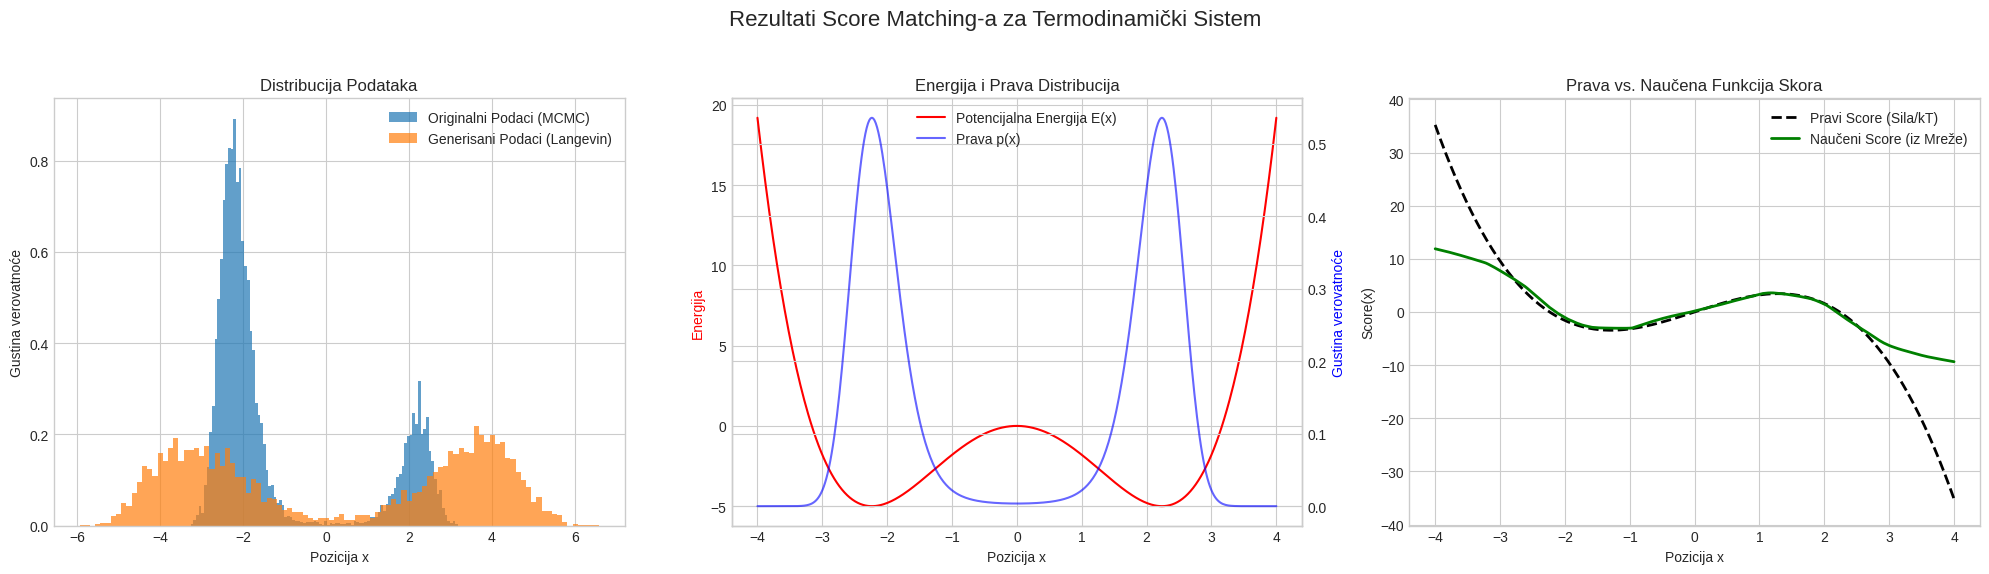

In [5]:
#================================================================
# 5. VIZUALIZACIJA REZULTATA
#================================================================
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Rezultati Score Matching-a za Termodinamički Sistem', fontsize=16)

# Plot 1: Originalna i generisana distribucija podataka
axes[0].hist(data.cpu().numpy(), bins=100, density=True, alpha=0.7, label='Originalni Podaci (MCMC)')
axes[0].hist(generated_samples, bins=100, density=True, alpha=0.7, label='Generisani Podaci (Langevin)')
axes[0].set_title('Distribucija Podataka')
axes[0].set_xlabel('Pozicija x')
axes[0].set_ylabel('Gustina verovatnoće')
axes[0].legend()

# Plot 2: Potencijalna energija i prava distribucija
x_range = np.linspace(-4, 4, 400)
E_x = energy_potential(torch.from_numpy(x_range)).numpy()
# Normalizujemo pravu distribuciju numericki za plotovanje
p_x_unnormalized = np.exp(-E_x / KT)
p_x = p_x_unnormalized / (np.trapz(p_x_unnormalized, x_range))

ax2_twin = axes[1].twinx()
axes[1].plot(x_range, E_x, 'r-', label='Potencijalna Energija E(x)')
ax2_twin.plot(x_range, p_x, 'b-', label='Prava p(x)', alpha=0.6)
axes[1].set_title('Energija i Prava Distribucija')
axes[1].set_xlabel('Pozicija x')
axes[1].set_ylabel('Energija', color='r')
ax2_twin.set_ylabel('Gustina verovatnoće', color='b')
lines, labels = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2_twin.legend(lines + lines2, labels + labels2, loc=0)


# Plot 3: Prava i naucena funkcija skora (sile)
x_tensor = torch.from_numpy(x_range).float().view(-1, 1).to(device)
# Gledamo nauceni score za najmanji sum, jer on odgovara cistim podacima
sigma_min = sigmas[-1].view(-1, 1).expand_as(x_tensor)

with torch.no_grad():
    learned_s = trained_model(x_tensor, sigma_min).cpu().numpy()

true_s = true_score(torch.from_numpy(x_range)).numpy()

axes[2].plot(x_range, true_s, 'k--', linewidth=2, label='Pravi Score (Sila/kT)')
axes[2].plot(x_range, learned_s, 'g-', linewidth=2, label='Naučeni Score (iz Mreže)')
axes[2].set_title('Prava vs. Naučena Funkcija Skora')
axes[2].set_xlabel('Pozicija x')
axes[2].set_ylabel('Score(x)')
axes[2].legend()
axes[2].set_ylim(np.min(true_s)-5, np.max(true_s)+5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()